<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/Demand_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Management and Merge Strategy

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

# Importing Cleaned Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_merged.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Mounted at /content/drive
(58327370, 22)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


# Item-store Level Category

In [ ]:
cols_to_keep = ['item_id', 'store_id', 'date', 'sales']
sales_uni = sales_long_val[cols_to_keep].copy()

In [ ]:
# Step 1: Set a sequence identifier
sales_uni['series_id'] = sales_uni['item_id'] + '_' + sales_uni['store_id']

# Step 2: Functions for calculating ADI and CV²
def compute_adi_cv2(df):
    demand_series = df['sales'].values
    nonzero_days = np.count_nonzero(demand_series)
    total_days = len(demand_series)

    # Avoid division by zero
    if nonzero_days == 0:
        adi = np.nan
        cv2 = np.nan
    else:
        # 1. ADI
        adi = total_days / nonzero_days

        # 2. CV²
        nonzero_demand = demand_series[demand_series > 0]
        if len(nonzero_demand) <= 1:
            cv2 = 0.0
        else:
            mean = np.mean(nonzero_demand)
            std = np.std(nonzero_demand, ddof=1)
            cv2 = (std / mean) ** 2 if mean != 0 else np.nan

    return pd.Series({'ADI': adi, 'CV2': cv2})

# Step 3: Calculate ADI and CV² for each item-store
adi_cv2_df = sales_uni.groupby('series_id').apply(compute_adi_cv2).reset_index()
adi_cv2_df.head()

,series_id,ADI,CV2
0,FOODS_1_001_CA_1,2.291018,0.555704
1,FOODS_1_001_CA_2,1.934277,0.715303
2,FOODS_1_001_CA_3,2.227008,1.157275
3,FOODS_1_001_CA_4,3.872470,0.313532
4,FOODS_1_001_TX_1,3.065705,0.993451


In [ ]:
sales_uni['series_id'].nunique()

30490

In [ ]:
# Label the four quadrants
def classify_demand(row):
    if pd.isnull(row['ADI']) or pd.isnull(row['CV2']):
        return 'Unclassified'
    elif row['ADI'] <= 1.32 and row['CV2'] <= 0.49:
        return 'Smooth'
    elif row['ADI'] <= 1.32 and row['CV2'] > 0.49:
        return 'Erratic'
    elif row['ADI'] > 1.32 and row['CV2'] <= 0.49:
        return 'Intermittent'
    else:
        return 'Lumpy'

adi_cv2_df['Demand_Type'] = adi_cv2_df.apply(classify_demand, axis=1)

adi_cv2_df.head()

,series_id,ADI,CV2,Demand_Type
0,FOODS_1_001_CA_1,2.291018,0.555704,Lumpy
1,FOODS_1_001_CA_2,1.934277,0.715303,Lumpy
2,FOODS_1_001_CA_3,2.227008,1.157275,Lumpy
3,FOODS_1_001_CA_4,3.872470,0.313532,Intermittent
4,FOODS_1_001_TX_1,3.065705,0.993451,Lumpy


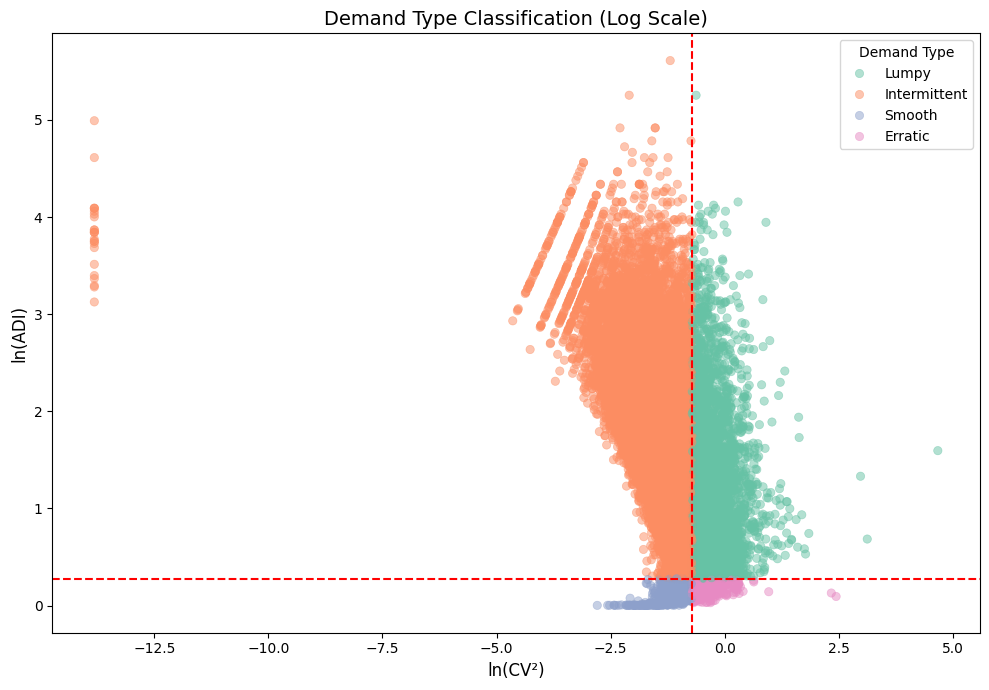

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add two columns of logarithmic variables (add 1 to prevent log(0))
adi_cv2_df['log_ADI'] = np.log(adi_cv2_df['ADI'] + 1e-6)
adi_cv2_df['log_CV2'] = np.log(adi_cv2_df['CV2'] + 1e-6)

# log-log plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=adi_cv2_df,
    x='log_CV2',
    y='log_ADI',
    hue='Demand_Type',
    palette='Set2',
    alpha=0.5,
    edgecolor=None
)

# Added log boundary line (CV² = 0.49, ADI = 1.32)
plt.axvline(np.log(0.49), color='red', linestyle='--')
plt.axhline(np.log(1.32), color='red', linestyle='--')


plt.title('Demand Type Classification (Log Scale)', fontsize=14)
plt.xlabel('ln(CV²)', fontsize=12)
plt.ylabel('ln(ADI)', fontsize=12)
plt.legend(title='Demand Type')
plt.tight_layout()
plt.show()


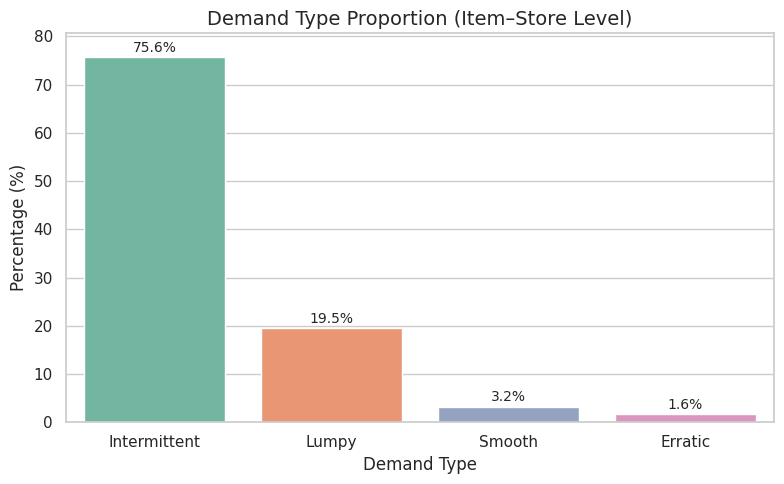

In [ ]:
sns.set(style="whitegrid")

# Count the number of each category
type_counts = adi_cv2_df['Demand_Type'].value_counts().reset_index()
type_counts.columns = ['Demand_Type', 'Count']

# Calculate the ratio
total = type_counts['Count'].sum()
type_counts['Percentage'] = type_counts['Count'] / total * 100


plt.figure(figsize=(8, 5))
sns.barplot(data=type_counts, x='Demand_Type', y='Percentage', palette='Set2')


for i, row in type_counts.iterrows():
    plt.text(i, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title('Demand Type Proportion (Item–Store Level)', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Demand Type')
plt.ylim(0, max(type_counts['Percentage']) + 5)

plt.tight_layout()
plt.show()


In [ ]:
adi_cv2_df.head()

,series_id,ADI,CV2,Demand_Type,log_ADI,log_CV2
0,FOODS_1_001_CA_1,2.291018,0.555704,Lumpy,0.828997,-0.587518
1,FOODS_1_001_CA_2,1.934277,0.715303,Lumpy,0.659734,-0.335047
2,FOODS_1_001_CA_3,2.227008,1.157275,Lumpy,0.800659,0.146069
3,FOODS_1_001_CA_4,3.872470,0.313532,Intermittent,1.353893,-1.159851
4,FOODS_1_001_TX_1,3.065705,0.993451,Lumpy,1.120278,-0.006570


In [ ]:
adi_cv2_df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Supervised Project/adi_cv2_df.pkl')

# Item-State Level Category

In [ ]:
items = sales_long_val['item_id'].unique()
states = sales_long_val['state_id'].unique()
dates = sales_long_val['date'].unique()

full_index = pd.MultiIndex.from_product(
    [items, states, dates],
    names=['item_id', 'state_id', 'date']
)

In [ ]:
sales_agg = (
    sales_long_val
    .groupby(['item_id', 'state_id', 'date'], as_index=False)['sales']
    .sum()
)


sales_state_full = (
    sales_agg
    .set_index(['item_id', 'state_id', 'date'])[['sales']]
    .reindex(full_index, fill_value=0)
    .reset_index()
)

In [ ]:
sales_state_full['series_id'] = (
    sales_state_full['item_id'] + '_' + sales_state_full['state_id']
)

print(sales_state_full['series_id'].nunique())

9147


In [ ]:
# Construct new series_id (item_state)

adi_cv2_state = (
    sales_state_full
    .groupby('series_id')
    .apply(compute_adi_cv2)
    .reset_index()
)


adi_cv2_state.head()

,series_id,ADI,CV2
0,FOODS_1_001_CA,1.224712,0.679632
1,FOODS_1_001_TX,1.537781,0.734702
2,FOODS_1_001_WI,1.667829,0.500584
3,FOODS_1_002_CA,1.273635,0.363626
4,FOODS_1_002_TX,2.288278,0.304425


In [ ]:
# Applies to item–state classification tables
adi_cv2_state['Demand_Type'] = adi_cv2_state.apply(classify_demand, axis=1)
adi_cv2_state.head()

,series_id,ADI,CV2,Demand_Type
0,FOODS_1_001_CA,1.224712,0.679632,Erratic
1,FOODS_1_001_TX,1.537781,0.734702,Lumpy
2,FOODS_1_001_WI,1.667829,0.500584,Lumpy
3,FOODS_1_002_CA,1.273635,0.363626,Smooth
4,FOODS_1_002_TX,2.288278,0.304425,Intermittent


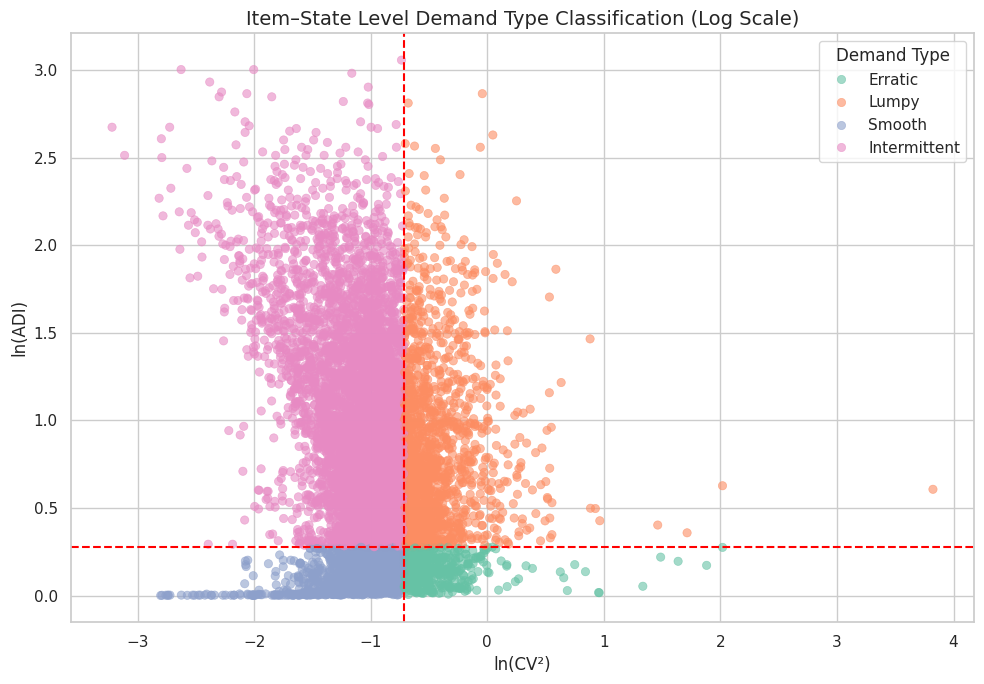

In [ ]:
# Log–Log Scatter Plot for Item–State Level Demand Classification
adi_cv2_state['log_ADI'] = np.log(adi_cv2_state['ADI'] + 1e-6)
adi_cv2_state['log_CV2'] = np.log(adi_cv2_state['CV2'] + 1e-6)


plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=adi_cv2_state,
    x='log_CV2',
    y='log_ADI',
    hue='Demand_Type',
    palette='Set2',
    alpha=0.6,
    edgecolor=None
)


plt.axvline(x=np.log(0.49), color='red', linestyle='--')
plt.axhline(y=np.log(1.32), color='red', linestyle='--')


plt.title('Item–State Level Demand Type Classification (Log Scale)', fontsize=14)
plt.xlabel('ln(CV²)', fontsize=12)
plt.ylabel('ln(ADI)', fontsize=12)
plt.legend(title='Demand Type')
plt.tight_layout()
plt.show()

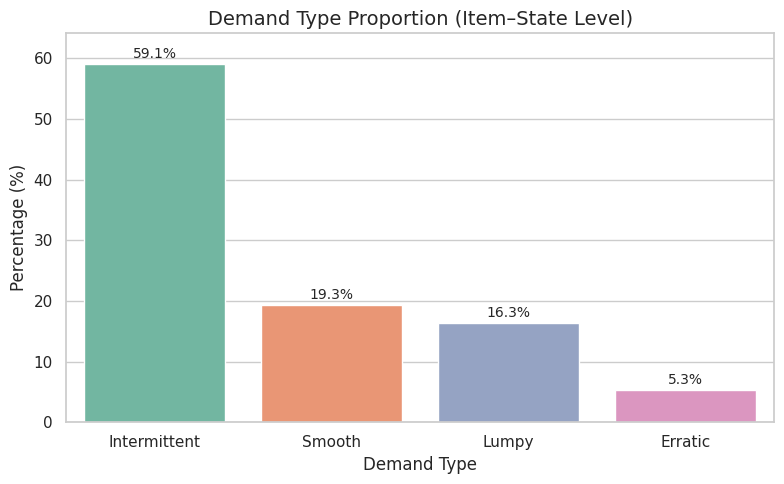

In [ ]:
# Demand type proportion
type_counts_state = adi_cv2_state['Demand_Type'].value_counts().reset_index()
type_counts_state.columns = ['Demand_Type', 'Count']


total_state = type_counts_state['Count'].sum()
type_counts_state['Percentage'] = type_counts_state['Count'] / total_state * 100


plt.figure(figsize=(8, 5))
sns.barplot(data=type_counts_state, x='Demand_Type', y='Percentage', palette='Set2')

for i, row in type_counts_state.iterrows():
    plt.text(i, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title('Demand Type Proportion (Item–State Level)', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Demand Type')
plt.ylim(0, max(type_counts_state['Percentage']) + 5)
plt.tight_layout()
plt.show()

In [ ]:
adi_cv2_state.to_pickle('/content/drive/MyDrive/Colab Notebooks/Supervised Project/adi_cv2_state.pkl')